



Converted mat data to CSV and imported as arrays.
Inported matplotlib and scipy to create PSDs




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave_model as wm
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from scipy import signal

#velocities are in m/s and the pressure is in decibars (1db = 10**4 Pa)
#convert afterwards by multiplying by 10**8 (conversion squared)
#  
CB_data = np.loadtxt('data/ADV_data_CB_out1.csv',delimiter=',',skiprows=1)
#data order: dn,P,u,v,w
CB_data = CB_data.transpose()

MV_data = np.loadtxt('data/ADV_data_MV_out1.csv',delimiter=',',skiprows=1)
#data order: dn,P,u,v,w
MV_data = MV_data.transpose()
datatypes = ["Pressure","HorizontalU Velocity","HorizontalV Velocity","Vertical Velocity"]
#MV: water depth is 16m
#    data was collected 0.4m above the seafloor (z = -15.6m)
#CB: water depth is 14m
#    data was collected 1.8m below the mean sea surface (z = -1.8m)
# sampling frequency of the instrument is 32Hz.
# time (dn)
# pressure (P)
# horizontal velocity (u & v)
# vertical velocity (w)







1.	Compute and plot the spectrum of pressure, vertical velocity and horizontal velocity (Suu+Svv) for both locations.

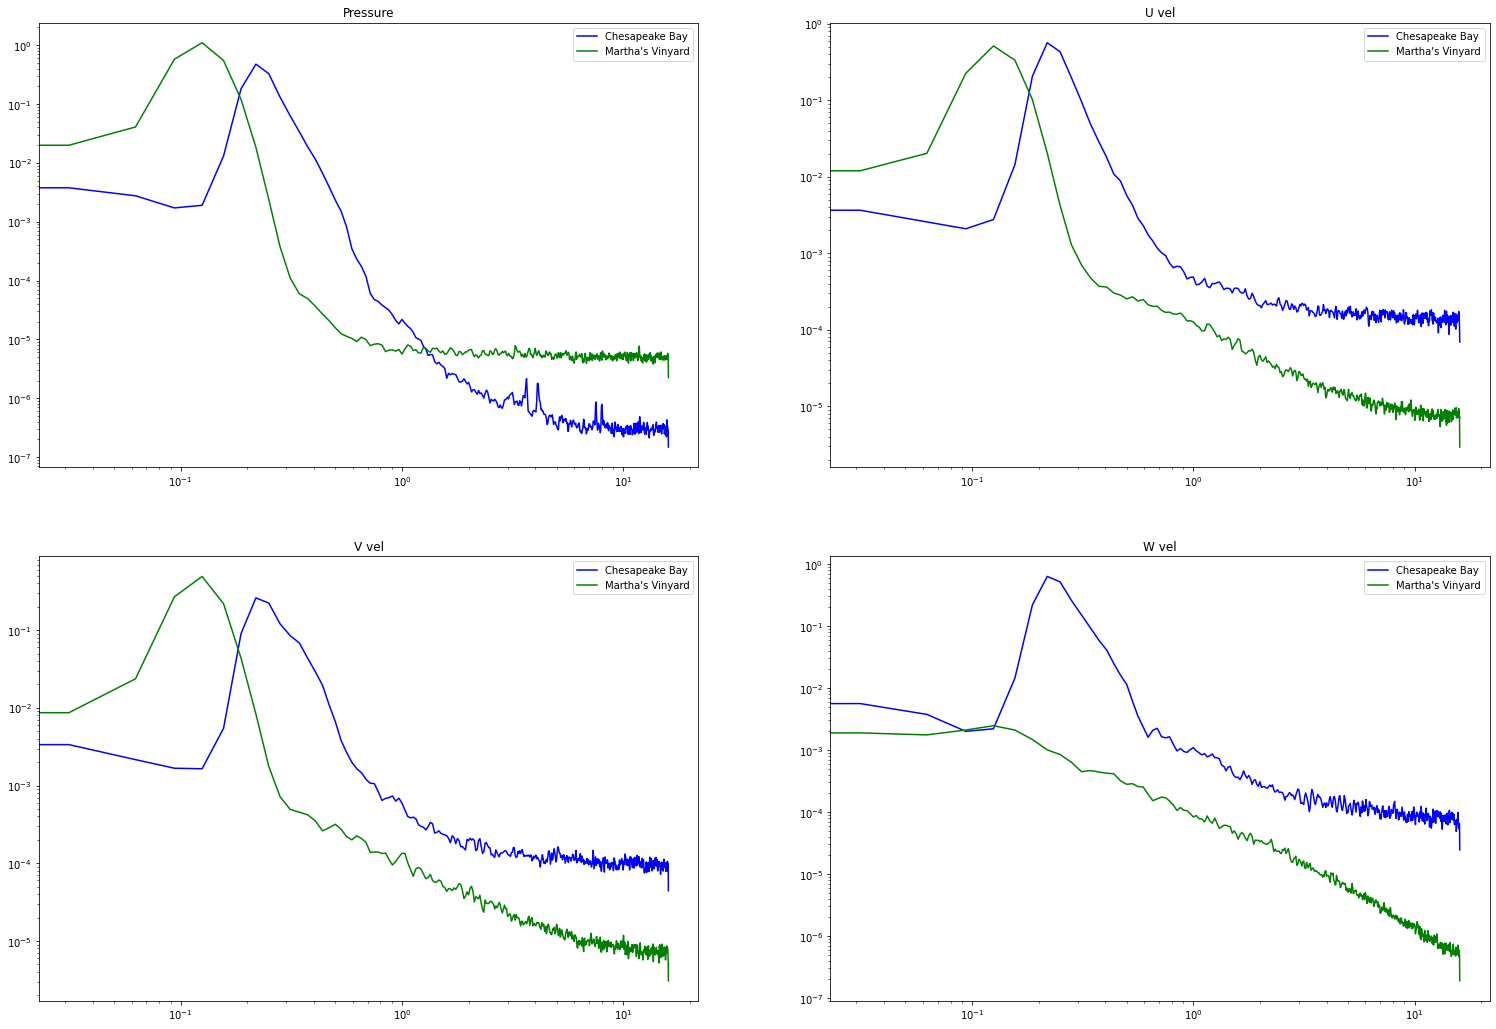

In [2]:
fig, ((ax0,ax2),(ax1,ax3)) = plt.subplots(2, 2,figsize=(26, 18))
i=0


plots = fig.get_axes()



titles = ["Pressure","U vel","V vel","W vel"]#dn,P,u,v,w
for i in range(4):

    f, Pxx_den = signal.welch(CB_data[i+1], 32, nperseg=1024)
    plots[i].loglog(f, Pxx_den,color="blue",label="Chesapeake Bay")
    
    f, Pxx_den = signal.welch(MV_data[i+1], 32, nperseg=1024)
    plots[i].loglog(f, Pxx_den,color="green",label="Martha's Vinyard")
    plots[i].legend(loc='upper right')
    plots[i].set_title(titles[i])



"""
ax1.set_title('Welch Settings:')
ax1.set_ylabel('')  # overwrite the y-label added by `psd`
ax1.grid(True)
#ax7.set_xlim(-10, 20)
"""
plt.show()







  Describe the differences between the locations and explain what might cause these differences:
In Martha's Vineyard I see the greatest energy at a lower frequency so longer wave period.  This could be explained by the test locations exposure to ocean waves.

I also see reduced vertical velocity in the MV data, likely because the sensor is close to the sea floor where vertical velocity approaches zero.

2.	Using the relationships for the pressure spectrum (Spp) and the horizontal velocity spectrum (Suu+Svv) given in class (Lecture Notes 9), derive an expression for the Spp in terms of Suu+Svv.  

Apply this expression at both locations and compare it to the observed pressure spectrum.  

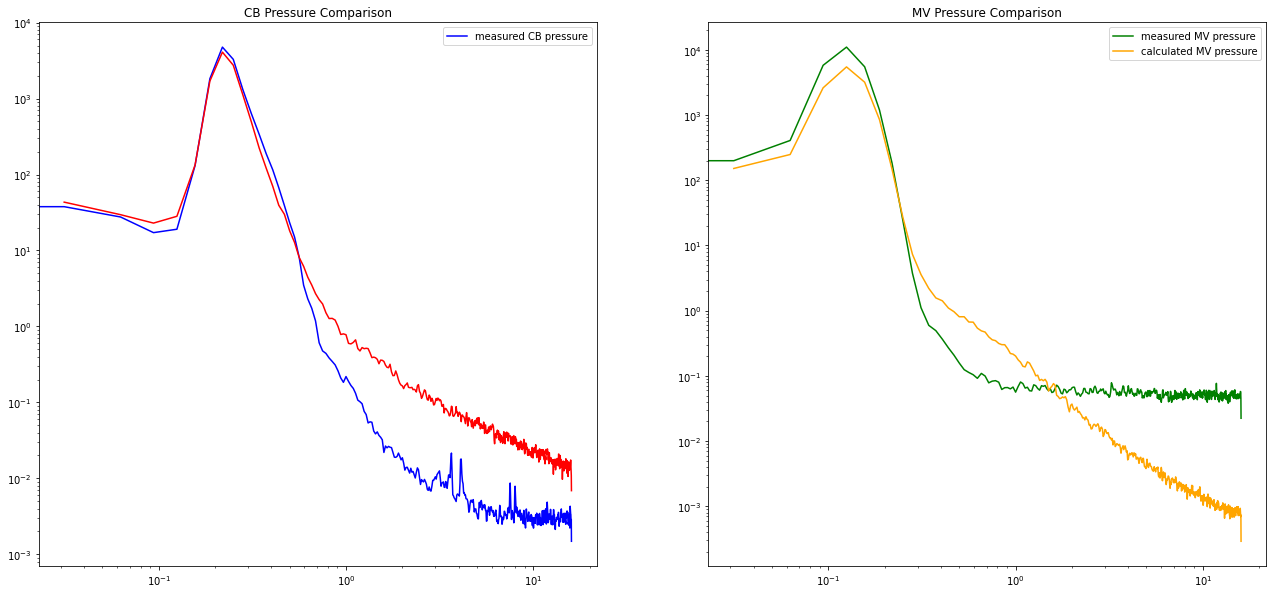

In [3]:

fig, (ax0,ax1) = plt.subplots(1, 2,figsize=(22, 10))
i=0
plots = fig.get_axes()
#dn,P,u,v,w
    
pf, CB_Pxx_press = signal.welch(CB_data[1], 32, nperseg=1024)
for i in range(len(CB_Pxx_press)):
    CB_Pxx_press[i] = CB_Pxx_press[i] * 10**4 # converting to pascals
plots[0].loglog(pf, CB_Pxx_press,color="blue",label="measured CB pressure")

pf, MV_Pxx_press = signal.welch(MV_data[1], 32, nperseg=1024)
for i in range(len(MV_Pxx_press)):
    MV_Pxx_press[i] = MV_Pxx_press[i] * 10**4 # converting to pascals
plots[1].loglog(pf, MV_Pxx_press,color="green",label="measured MV pressure")


uf, pp_CB_Pxx_U = signal.welch(CB_data[2], 32, nperseg=1024)
for i in range(len(pp_CB_Pxx_U)):
    pp_CB_Pxx_U[i] = wm.uu_to_pp(pp_CB_Pxx_U[i],uf[i],14,-1.8)
    #pp_CB_Pxx_U[i] += 1.8#adding depth to variance to get total pressure in decibars
plots[0].loglog(uf, pp_CB_Pxx_U,color="red")
plots[0].set_title('CB Pressure Comparison')
plots[0].legend(loc='upper right')

uf, pp_MV_Pxx_U = signal.welch(MV_data[2], 32, nperseg=1024) #calculate initial spectrum
for i in range(len(pp_MV_Pxx_U)):
    pp_MV_Pxx_U[i] = wm.uu_to_pp(pp_MV_Pxx_U[i],uf[i],16,-15.6) #update spectrum to calculated pressure
    #pp_MV_Pxx_U[i] += 15.6#adding depth to variance to get total pressure in decibars
plots[1].loglog(uf, pp_MV_Pxx_U,color="orange",label="calculated MV pressure")
plots[1].set_title('MV Pressure Comparison')
plots[1].legend(loc='upper right')

plt.show()

Are they consistent? Briefly summarize.

At low and medium frequencies the calculated pressure spectrum appears consistent.  At higher frequencies, they diverge.  In the Chesapeake, the caculated high freg pressure approaches the measured noise floor more gradually.  This is not what I expected to see, but does align with the measured U velocity.

In the Martha's Vinyard data the calculated pressure approaches zero at high frequency through the measured noise floor which is what I expected to see.

3.	Derive the relationship between the pressure spectrum (Spp) and the vertical velocity spectrum (Sww).  

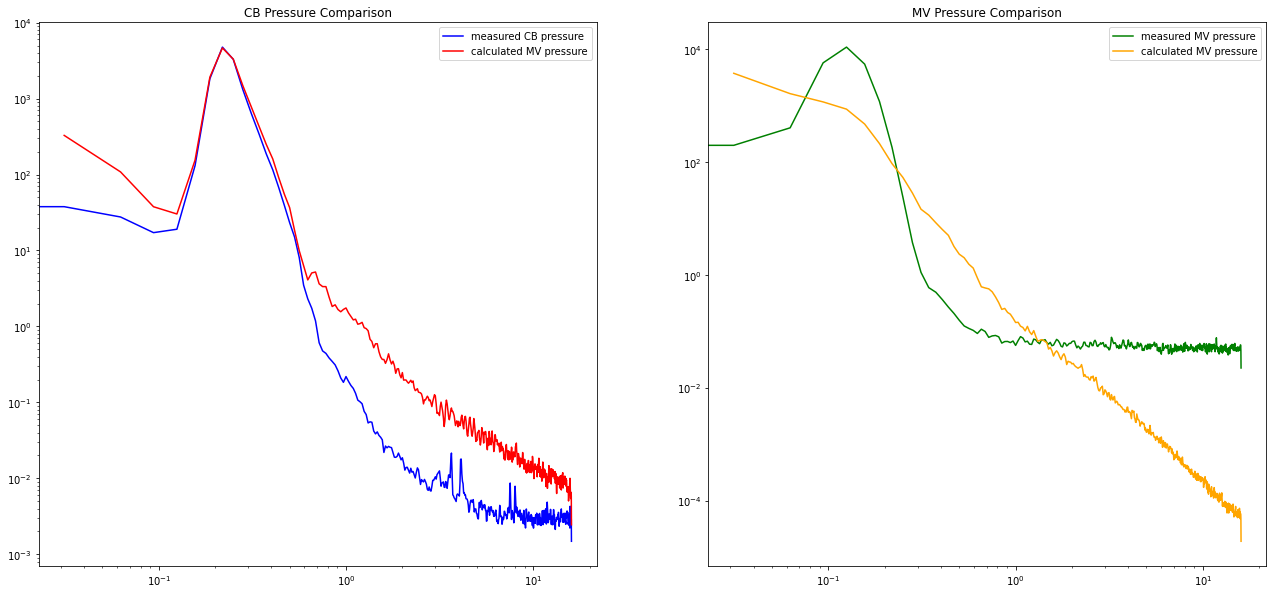

In [4]:
fig, (ax0,ax1) = plt.subplots(1, 2,figsize=(22, 10))
i=0
plots = fig.get_axes()
#dn,P,u,v,w

 
    
pf, CB_Pxx_press = signal.welch(CB_data[1], 32, nperseg=1024)
for i in range(len(CB_Pxx_press)):
    CB_Pxx_press[i] = CB_Pxx_press[i] * 10**4 # converting to pascals
plots[0].loglog(pf, CB_Pxx_press,color="blue",label="measured CB pressure")



pf, MV_Pxx_press = signal.welch(MV_data[1], 32, nperseg=1024)
for i in range(len(MV_Pxx_press)):
    MV_Pxx_press[i] = MV_Pxx_press[i] * 10**4 # converting to pascals
plots[1].loglog(pf, MV_Pxx_press,color="green",label="measured MV pressure")



wf, pp_CB_Pxx_W = signal.welch(CB_data[4], 32, nperseg=1024)
for i in range(len(pp_CB_Pxx_W)):
    pp_CB_Pxx_W[i] = wm.ww_to_pp(pp_CB_Pxx_W[i],wf[i],14,-1.8)
plots[0].loglog(wf, pp_CB_Pxx_W,color="red",label="calculated MV pressure")
plots[0].set_title('CB Pressure Comparison')
plots[0].legend(loc='upper right')



wf, pp_MV_Pxx_W = signal.welch(MV_data[4], 32, nperseg=1024)
for i in range(len(pp_MV_Pxx_W)):
    pp_MV_Pxx_W[i] = wm.ww_to_pp(pp_MV_Pxx_W[i],wf[i],16,-15.6)
plots[1].loglog(wf, pp_MV_Pxx_W,color="orange",label="calculated MV pressure")
plots[1].set_title('MV Pressure Comparison')
plots[1].legend(loc='upper right')



plt.show()

Compare the observed pressure spectrum to the relationship derived from vertical velocity:

    There is greater divergence between the measured pressure and the pressuce calculated from the vertical velocity.

    If this is not a problem with the implementation, it could be due to the reduced vertical velocity signal below the surface.  Where measurements are made close to the suface in the Chesapeake the calculated pressure is closer to measured.  With the deep sensor it deviates dramatically.

4. 	Explain how the pressure spectra under surface waves would change depending on the depth beneath the surface where the measurement is made.  Provide a quantitative example to illustrate this.

The wave induced pressure would diminish as the depth below the surface increases, leaving only the static pressure from the weight of the water column.  Pressure measurements made farther below the surface would have a lower signal at wave frequencies.

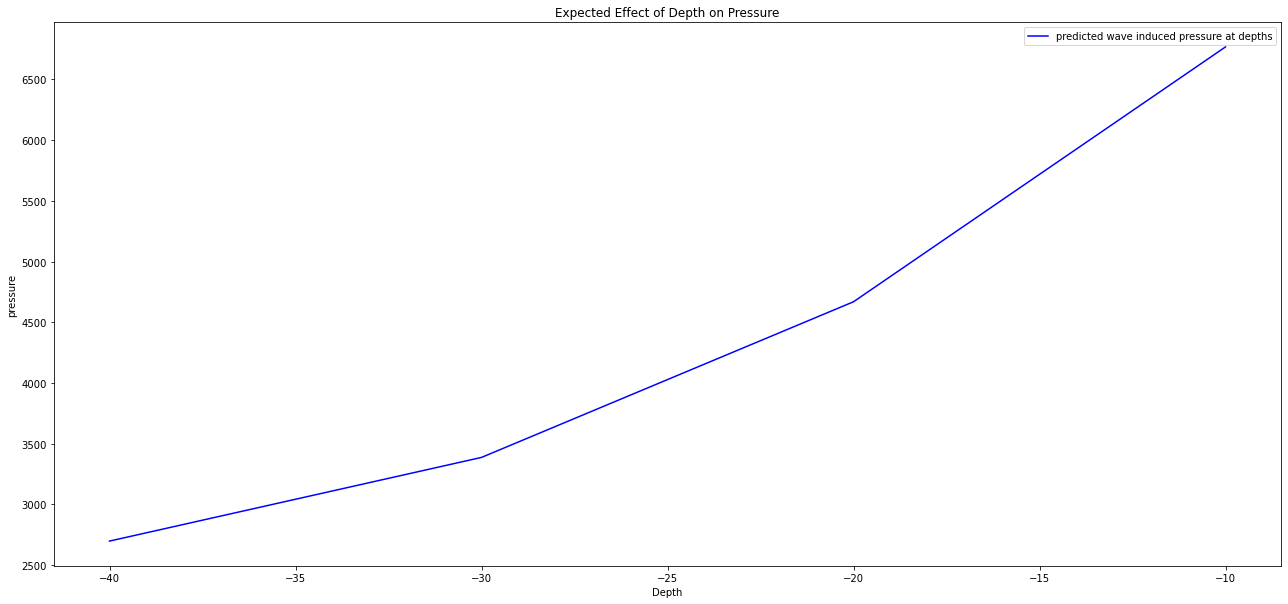

In [5]:
depths=[-10,-20,-30,-40] # depths to calculate pressure from U velocity with MV data

pressure_example_wave = wm.wave_solver(measuredperiod=10,init_depth=50,measuredamplitude=1)
pressure_range = []
fig, (ax0) = plt.subplots(1,figsize=(22, 10))
for depth in depths:
    pressure_range.append(pressure_example_wave.wave_pressure(depth))

plots = fig.get_axes()
plots[0].plot(depths, pressure_range,color="blue",label="predicted wave induced pressure at depths")
plots[0].set_xlabel("Depth");plots[0].set_ylabel("pressure")
plots[0].legend(loc='upper right')
plots[0].set_title('Expected Effect of Depth on Pressure')
plt.show()

5.	Calculate the significant wave height (Hs) and wave period (T) from the pressure spectrum for each data set.  For the calculation of Hs assume that the pressure signal is only driven by the hydrostatic response to the sea surface and that 1 decibar = 1m of sea level.  Compare these estimates to estimates made from zero crossing with the same assumptions.   

First, calculate up-crossing is whenever ada goes from below mean to above mean.
Pressure represents height of water column above sensor so mean pressure represents z=0
subtract mean and identify where pressure changes from - to +

In [6]:
print("Calculated using up-crossings")
#get up crossings
CB_ups = wm.up_crossings(CB_data[1])
MV_ups = wm.up_crossings(MV_data[1])
#use up crossings to get period and height
CB_periods,CB_heights = wm.height_from_up_crossings(CB_data[1],CB_ups)
MV_periods,MV_heights = wm.height_from_up_crossings(MV_data[1],MV_ups)
#get significant period and height
print("MV significant period: ",wm.return_significant(MV_periods),"MV significant heights: ",wm.return_significant(MV_heights))
print("CB significant period: ",wm.return_significant(CB_periods),"CB significant heights: ",wm.return_significant(CB_heights))

Calculated using up-crossings
mean depth:  1.827393439256175
mean depth:  15.568207105654764
MV significant period:  8.174952651515152 MV significant heights:  0.9000706371753202
CB significant period:  4.838874113475177 CB significant heights:  0.7513691498564442


Next calculate wave heights and period from spectra

In [7]:
from scipy import stats
import spectrum_methods as sm

pf, MV_Pxx_press = signal.welch(MV_data[1], 32, nperseg=1024)
pdf_array=[]
for i in range(len(MV_Pxx_press)):
    pdf_array.append([pf[i],MV_Pxx_press[i]])


#still getting these moments calculated...The concept of these moments
#of the spectrum makes sense but the results of these calculations does not
arr = np.array(pdf_array)

#calculating moments
m0 = stats.moment(arr,axis=1,moment=0)
m1 = stats.moment(arr,axis=1,moment=1)
m2 = stats.moment(arr,axis=1,moment=2)
m3 = stats.moment(arr,axis=1,moment=3)

tp = np.sqrt((m0)/(m2)) #average period from moments -- results are not making sense to me

average_period = np.mean(tp) #trying to get array of moments along x axis and then mean?
print("MV average period from moments: ",average_period,"MV average period from up-crossing calc: ",np.mean(MV_periods))

MV average period from moments:  1.5384822981745148 MV average period from up-crossing calc:  4.2196945843828715


In [8]:
pf, CB_Pxx_press = signal.welch(CB_data[1], 32, nperseg=1024)
pdf_array=[]
for i in range(len(CB_Pxx_press)):
    pdf_array.append([pf[i],CB_Pxx_press[i]])


#still getting these moments calculated...The concept of these moments
#of the spectrum makes sense but the results of these calculations do not
arr = np.array(pdf_array)

#calculating moments
m0 = stats.moment(arr,axis=1,moment=0)
m1 = stats.moment(arr,axis=1,moment=1)
m2 = stats.moment(arr,axis=1,moment=2)
m3 = stats.moment(arr,axis=1,moment=3)


tp = np.sqrt((m0)/(m2)) #average period from moments -- results are not making sense to me

average_period = np.mean(tp) #trying to get array of moments along x axis and then mean?
print("CB average period from moments: ",average_period,"CB average period from up-crossing calc: ",np.mean(MV_periods))

CB average period from moments:  4.142227869274779 CB average period from up-crossing calc:  4.2196945843828715
